1. **[OBTAIN](#OBTAIN)**
    - Import data, inspect, check for datatypes to convert and null values
    - Display header and info.
    - Drop any unneeded columns, if known (`df.drop(['col1','col2'],axis=1,inplace=True`)
    <br><br>


2. **[SCRUB](#SCRUB)**
    - Recast data types, identify outliers, check for multicollinearity, normalize data**
    - Check and cast data types
        - [ ] Check for #'s that are store as objects (`df.info()`,`df.describe()`)
            - when converting to #'s, look for odd values (like many 0's), or strings that can't be converted.
            - Decide how to deal weird/null values (`df.unique()`, `df.isna().sum()`)
            - `df.fillna(subset=['col_with_nulls'],'fill_value')`, `df.replace()`
        - [ ] Check for categorical variables stored as integers.
            - May be easier to tell when you make a scatter plotm or `pd.plotting.scatter_matrix()`
            
    - [ ] Check for missing values  (df.isna().sum())
        - Can drop rows or colums
        - For missing numeric data with median or bin/convert to categorical
        - For missing categorical data: make NaN own category OR replace with most common category
    - [ ] Check for multicollinearity
        - Use seaborn to make correlation matrix plot 
        - Good rule of thumb is anything over 0.75 corr is high, remove the variable that has the most correl with the largest # of variables
    - [ ] Normalize data (may want to do after some exploring)
        - Most popular is Z-scoring (but won't fix skew) 
        - Can log-transform to fix skewed data
    
    
3. **[EXPLORE](#EXPLORE)**
    - [ ] Check distributions, outliers, etc**
    - [ ] Check scales, ranges (df.describe())
    - [ ] Check histograms to get an idea of distributions (df.hist()) and data transformations to perform.
        - Can also do kernel density estimates
    - [ ] Use scatter plots to check for linearity and possible categorical variables (`df.plot("x","y")`)
        - categoricals will look like vertical lines
    - [ ] Use `pd.plotting.scatter_matrix(df)` to visualize possible relationships
    - [ ] Check for linearity.
   
   
4. **[MODEL](#MODEL)**

    - **Fit an initial model:** 
        - Run an initial model and get results

    - **Holdout validation / Train/test split**
        - use sklearn `train_test_split`
    
    
5. **[iNTERPRET](#iNTERPRET)**
    - **Assessing the model:**
        - Assess parameters (slope,intercept)
        - Check if the model explains the variation in the data (RMSE, F, R_square)
        - *Are the coeffs, slopes, intercepts in appropriate units?*
        - *Whats the impact of collinearity? Can we ignore?*
        <br><br>
    - **Revise the fitted model**
        - Multicollinearity is big issue for lin regression and cannot fully remove it
        - Use the predictive ability of model to test it (like R2 and RMSE)
        - Check for missed non-linearity
        
       
6. **Interpret final model and draw >=3 conclusions and recommendations from dataset**

# Product Sentiment Analysis - NLP

* Student name: Robert Cauvy 
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Claude Fried

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

Hired by Apple to determine which product release has the more positive sentiment and how it compared to their competitor Google who had also just released a new service.

Over the past decade conversations have increasingly shifted towards social media. Businesses across all industries could stand to benefit from listening to these conversations about themselves and how their products and brand are perceived by they users and prospective customers. Understanding what it is that customers enjoy the most and the least about your company's products and brand is crucial to retaining your loyal customers as well as attracting new ones.

When large companies announce their new product releases at conferences and keynotes, they can obtain useful market insights and feedback from public opinion. A great source to measure market reactions is the giant social media network, Twitter.

In addition to analyzing tweets various machine learning models will be trained and tested to classify tweets as either positive or negative sentiments towards the companies products and services. 

## Business Problem

It is not easy to obtain unbiased and unfiltered feedback and opinions from the public. Understanding how the market feels about the products and services delivered by your brand in real-time can provide valuable insights that could not get captured before the ubiquity of social media. Applying human capital to track social networks is simply not a scalable solution which makes the application of Natural Language Processing and Machine Learning classifiers well suited for this business problem.

The objective of this project is provide the businesses (Apple and Google) a model that identifies which tweets hold either a positive or negative sentiment about their brand or products from a corpus of tweets. Furthermore, this project will provide the stakeholders with a list of topics and keywords that most affect public perception, leaving actionable insights for future marketing and product design decisions.


# OBTAIN

In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

pd.set_option("display.max_colwidth", 300)

## Data Understanding

This project is utilizing a dataset  provided by CrowdFlower to from data.world. The dataset contains over 9,000 tweets from SXSW(South by Southwest) Conference about new product releases from Apple and Google. The tweet have been labeled as to which emotion they convey towards a particular product category or company brand based off of the language contained in the tweet.

According to the provider of the dataset, humans that were tasked with labeling the sentiments of each tweet by evaluating which brand or product the tweet was about and if the tweet expressed positive, negative, or no emotion towards a brand and/or product.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## NLP Imports
import nltk
from nltk import FreqDist,word_tokenize,regexp_tokenize,TweetTokenizer
from nltk.corpus import stopwords
import string

In [4]:
df = pd.read_csv('data/tweet_product.csv', encoding= 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [5]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [6]:
# renaming columns to reduce verbosity
df = df.rename(columns={"tweet_text": "text", 
                   "emotion_in_tweet_is_directed_at": "product",
                  "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"
                  }
         )

In [68]:
#Cleaning up the values in sentinemts for easier interpretability

sentiment_dict = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
df['sentiment'] = df['sentiment'].map(sentiment_dict)
df.head()

,text,product,sentiment,raw_token_count,token_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,29,29
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,26,26
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,17,17
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,16,16
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,27,27


In [69]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9066 entries, 0 to 9092
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             9066 non-null   object
 1   product          3280 non-null   object
 2   sentiment        9066 non-null   object
 3   raw_token_count  9066 non-null   int64 
 4   token_count      9066 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 745.0+ KB


In [8]:
## Create a variable "corpus" containing all text
df['text'] = df['text'].astype(str)

corpus = df['text'].to_list()

## Preview first 5 entries 
corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"]

In [9]:
## Check for nulls
def null_check(df):
    """Returns a dataframe of null value counts andd %'s'"""
    nulls = df.isna().sum()
    return pd.DataFrame({'nulls':nulls,
                  '%null':nulls/len(df)*100}).round(2)
null_check(df)

,nulls,%null
text,0,0.00
product,5802,63.81
sentiment,0,0.00


*Nearly two thirds of tweets were labeled as having no emotion directed towards a specific brand or product.*

# Scrub

## Data Preparation

In [11]:
# check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

27

In [14]:
# Take a look at duplicated records
duplicates = df.duplicated(subset=['text'], keep=False)
df.loc[duplicates.loc[duplicates==True].index].sort_values(by='text')

,text,product,sentiment
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
774,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
776,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
8483,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion


In [16]:
# drop duplicates
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
# check for duplicates
df.duplicated(subset=['text'], keep='first').sum()

0

In [17]:
# check for URLs
df[df['text'].str.contains("http[^ ]+|www\.[^ ]+")]

,text,product,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,Android App,Positive emotion
12,"Foursquare ups the game, just in time for #SXS...",Android App,Positive emotion
13,Gotta love this #SXSW Google Calendar featurin...,Other Google product or service,Positive emotion
14,Great #sxsw ipad app from @madebymany: http://...,iPad or iPhone App,Positive emotion
15,"haha, awesomely rad iPad app by @madebymany ht...",iPad or iPhone App,Positive emotion
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
19,Must have #SXSW app! RT @malbonster: Lovely re...,iPad or iPhone App,Positive emotion
23,"Photo: Just installed the #SXSW iPhone app, wh...",iPad or iPhone App,Positive emotion


In [18]:

# check for non-ASCII characters
df[df['text'].str.contains('[^\x00-\x7F]+')]

,text,product,sentiment
38,@mention - False Alarm: Google Circles Not Co...,Google,Negative emotion
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,NaN,No emotion toward brand or product
42,Hey #SXSW - How long do you think it takes us ...,NaN,No emotion toward brand or product
45,#IPad2 's Û÷#SmartCoverÛª Opens to Instant A...,iPad or iPhone App,Positive emotion
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive emotion
...,...,...,...
8925,umm that would be @mention ÛÏ@mention I keep ...,Other Apple product or service,Positive emotion
8945,FestivalExplorer iPhone App Finally Solves SXS...,iPad or iPhone App,Positive emotion
8963,Group #Texting War Heats Up: Fast Society Laun...,Android App,Positive emotion
8982,In case my fairy god mother = reading mail; my...,NaN,No emotion toward brand or product


# EXPLORE

After going through some initial scrubbing of the dataset it is time to explore some of the characteristics of the tweet data. During this EDA phase, we will inspect the class balance, distribution of tweet lengths, WordClouds and most common words for each class. 

Because we are working with Twitter data, we'll work with nltk's TweetTokenizer and customize  stop words to get a better view of the content of the tweets for addressing the questions.

In [71]:
df['sentiment'].unique()

array(['Negative', 'Positive', 'Neutral', 'Unknown'], dtype=object)

In [74]:
sentiment_order = ('Negative', 'Positive',
       'Neutral', "Unknown")

sentiment_order

('Negative', 'Positive', 'Neutral', 'Unknown')

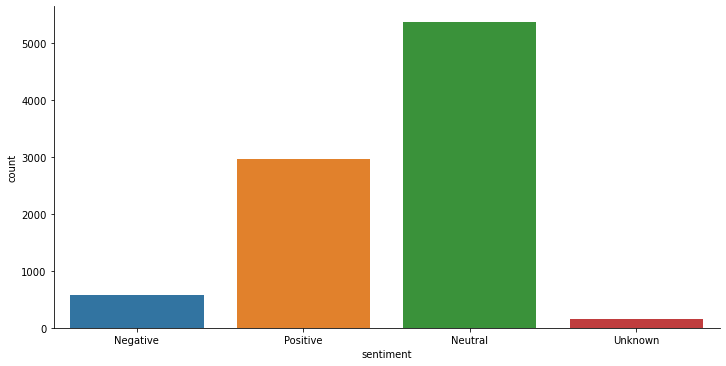

In [75]:
## Overall sentiment distribution
sns.catplot(data=df,x='sentiment',kind='count',order=sentiment_order,aspect=2);

#### Examing the class distributions

In [76]:
df['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Unknown      156
Name: sentiment, dtype: int64

In [77]:
df['sentiment'].value_counts(normalize=True)

Neutral     0.592654
Positive    0.327377
Negative    0.062762
Unknown     0.017207
Name: sentiment, dtype: float64

Less than half of the tweets were classified as having any emotion. Of the tweets which were tagged as having an emotion, most were coded positive. About 3,000 tweets compared to only 570 tweets that were tagged as having negative emotion.

In [78]:
df[df['sentiment']=='Unknown']

,text,product,sentiment,raw_token_count,token_count
90,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh,NaN,Unknown,23,23
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,NaN,Unknown,29,29
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,Unknown,23,23
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,NaN,Unknown,17,17
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},NaN,Unknown,22,22
...,...,...,...,...,...
9020,It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW,NaN,Unknown,30,30
9032,"@mention yeah, we have @mention , Google has nothing on us :) #SXSW",NaN,Unknown,14,14
9037,"@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw",NaN,Unknown,15,15
9058,&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?,NaN,Unknown,30,30


These tweets labeled as unknown are difficult to classify without more context and could be viewed as sarcastic.
All tweets in the corpus will need to be classified for modeling later on and the volume accounts for less than 2% of the corpus it is safe to drop these records.

In [79]:
df = df[df['sentiment']!='Unknown']
df['sentiment'].value_counts(normalize=True)

Neutral     0.603030
Positive    0.333109
Negative    0.063861
Name: sentiment, dtype: float64

### Make a Bag-of-Words Frequency Distribution

In [24]:
# Tokenize corpus then generate FreqDist
# Convert Corpus to Tokens
tokens = word_tokenize(','.join(corpus))

# Check first 5 tokens
print(tokens[:5])

['.', '@', 'wesley83', 'I', 'have']


In [26]:
# Get FreqDist and plot the 25 most_common tokens
freq = FreqDist(tokens)
freq.most_common(25)

[('#', 15875),
 (',', 12554),
 ('@', 7194),
 ('mention', 7119),
 ('.', 4929),
 ('SXSW', 4737),
 ('sxsw', 4478),
 ('link', 4311),
 ('}', 4298),
 ('{', 4296),
 ('the', 3928),
 ('to', 3519),
 ('RT', 2947),
 ('at', 2859),
 (';', 2800),
 ('&', 2707),
 ('for', 2440),
 ('!', 2398),
 ('a', 2174),
 ('Google', 2135),
 ('iPad', 2116),
 (':', 2075),
 ('Apple', 1880),
 ('in', 1830),
 ('quot', 1696)]

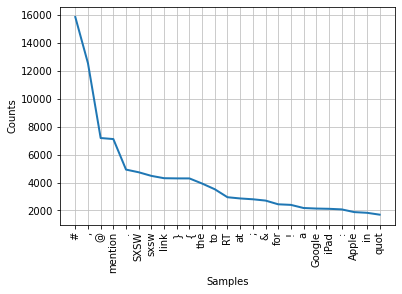

In [19]:
freq.plot(25);

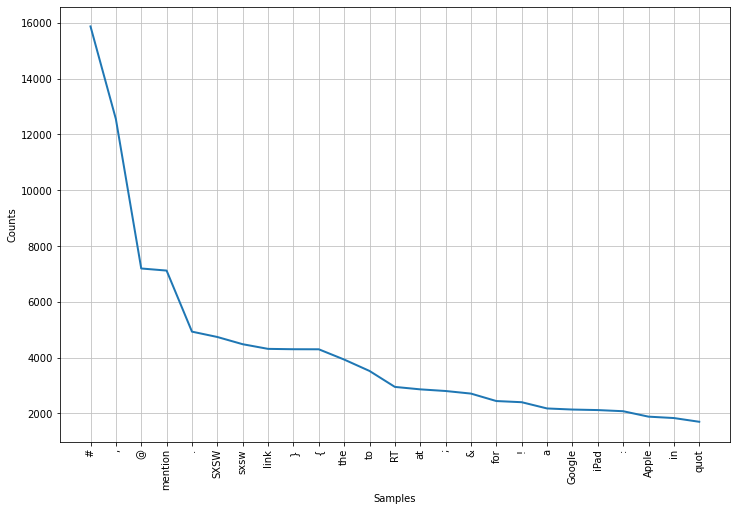

<ipython-input-22-814bc27432ef>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


In [22]:
fig, ax = plt.subplots(figsize=(12,8))
freq.plot(25);

## Rotate 
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,ha='right');
fig.show();

<AxesSubplot:ylabel='word'>

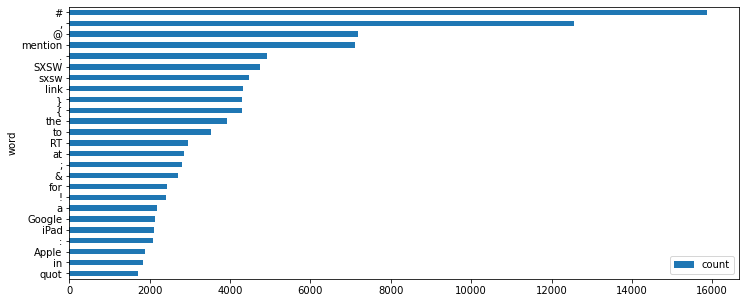

In [23]:
## Get the most_common 100 and make into a dataframe
most_common = pd.DataFrame(freq.most_common(100),
                           columns=['word','count']).sort_values('count',
                                                                 ascending=True)
most_common.set_index('word').tail(25).plot(kind='barh',figsize=(12,5))

In [24]:
most_common


,word,count
99,Today,250
98,ipad,251
97,'m,254
96,all,256
95,they,258
...,...,...
4,.,4929
3,mention,7119
2,@,7194
1,",",12554


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


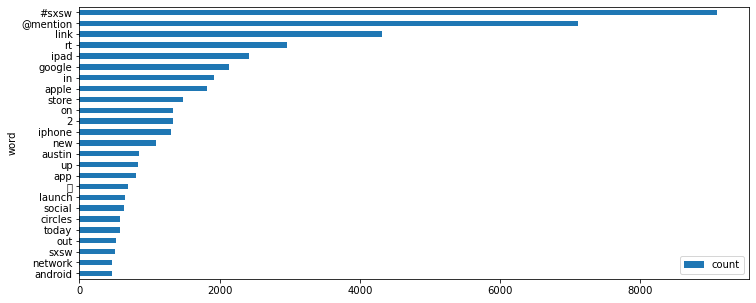

In [40]:
def plot_most_common(freq,n=25,figsize=(12,5)):
    most_common = pd.DataFrame(freq.most_common(n),
                           columns=['word','count']).sort_values('count',
                                                                 ascending=True)
    most_common.set_index('word').tail(n).plot(kind='barh',figsize=figsize)
    
plot_most_common(freq)

In [36]:
from nltk import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False,)
tweet_tokens = tokenizer.tokenize(','.join(corpus))
tweet_tokens[:20]

['.',
 '@wesley83',
 'i',
 'have',
 'a',
 '3g',
 'iphone',
 '.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'i']

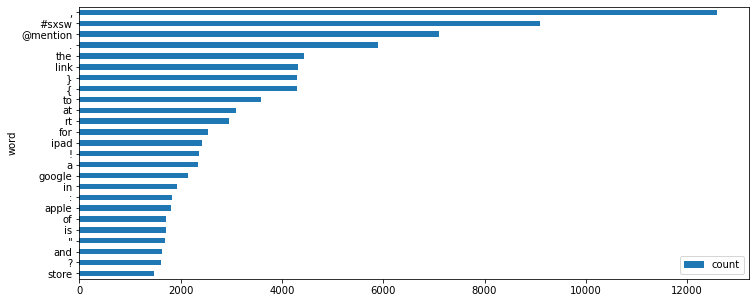

In [27]:
## Make a new freq dist for tweet tokens and plot most common
tweet_freq = FreqDist(tweet_tokens)
plot_most_common(tweet_freq)

In [155]:
## Make a list of stopwords to remove
from nltk.corpus import stopwords
import string

In [156]:
# Get all the stop words in the English language and preview first 10
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The stopwords list contains a good amount of words that can be used to express emotion. For this project, we'll use a more pared down list of custom stopwords.

In [157]:
# customized smaller list of stopwords
custom_stopwords = ['i', 'me', 'my', 'myself', 'in', 'on', 'out','up','we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'of', 'at', 'by', 'for', 'with', 'about', 'into', 'through', 'to', 'from','then', 'no', 'nor', 'not', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'wasn']

In [158]:
## Add punctuation to stopwords_list
custom_stopwords.extend(string.punctuation)
custom_stopwords[-10:]

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [159]:
## Add the additional Tweet Punctuation below to stopwords_list
additional_punc = ['“','”','...',"''",'’','``']
custom_stopwords.extend(additional_punc)

In [160]:
#### Appending our stopwords list
custom_stopwords.extend(['…','rt','http','https','co'])
custom_stopwords[-1]

'co'

In [161]:
sxsw_stopwords = [custom_stopwords, 'sxsw', '#sxsw', '#sxswi','mention', '@mention', 
                  'google', 'apple', 'iphone','link' ,'rt']

In [162]:
sxsw_stopwords

[['i',
  'me',
  'my',
  'myself',
  'in',
  'on',
  'out',
  'up',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'into',
  'through',
  'to',
  'from',
  'then',
  'no',
  'nor',
  'not',
  'so',
  'than',
  'too',
  'very',
  's',
  't',
  'can',
  'will',
  'just',
  'don',
  'now',
  'd',
  'll',
  'm',
  'o',
  're',
  '

In [177]:
## Remove stopwords
stopped_tokens= [w.lower() for w in tweet_tokens  if w.lower() not in sxsw_stopwords]
stopped_tokens[:20]

['.',
 '@wesley83',
 'i',
 'have',
 'a',
 '3g',
 '.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'i',
 'need']

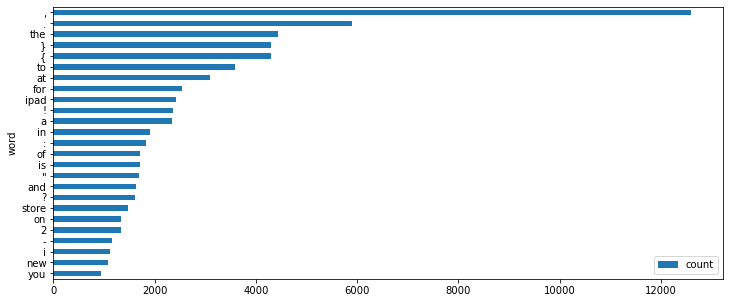

In [164]:
## Remake the FreqDist from stopped_tokens
freq = FreqDist(stopped_tokens)
plot_most_common(freq,25)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


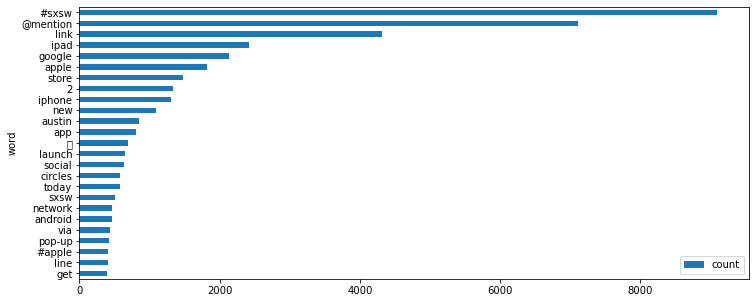

In [165]:
## Remake the FreqDist from stopped_tokens
stopped_tokens= [w.lower() for w in tweet_tokens  if w.lower() not in custom_stopwords]
freq = FreqDist(stopped_tokens)
# freq.most_common(100)
plot_most_common(freq,25)

Since the business problem we are looking to solve requires understanding differences between positive and negative sentiments, it is essential that posiitive and negative twwets are separated for the exploration process.

In [137]:
#separating positive and negative tweets into new dfs
positive_df = df[df['sentiment']=='Positive']
negative_df = df[df['sentiment']=='Negative']

In [138]:
positive_df.head()

,text,product,sentiment,raw_token_count,token_count
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,26,26
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,17,17
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,27,27
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive,30,30
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive,18,18


In [139]:
negative_df.head()

,text,product,sentiment,raw_token_count,token_count
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,29,29
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,16,16
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative,26,26
38,@mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW,Google,Negative,24,24
64,Again? RT @mention Line at the Apple store is insane.. #sxsw,NaN,Negative,13,13


In [140]:
positive_corpus = positive_df['text'].to_list()
positive_corpus[:5]

["@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB']

In [141]:
negative_corpus = negative_df['text'].to_list()
negative_corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone',
 '@mention  - False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW',
 'Again? RT @mention Line at the Apple store is insane.. #sxsw']

In [153]:
positive_tokens = [w.lower() for w in tweet_tokens  if w.lower() not in sxsw_stopwords]

## Most Common Words Found In Positive Tweets

In [143]:
def find_most_common(tokens, n=50):
    freq = FreqDist(tokens)
    display(freq.most_common(n))

In [154]:
# print 50 most common words from positive tweets
find_most_common(positive_tokens)

[(',', 12593),
 ('.', 5896),
 ('the', 4430),
 ('}', 4298),
 ('{', 4295),
 ('to', 3589),
 ('at', 3100),
 ('for', 2546),
 ('ipad', 2413),
 ('!', 2366),
 ('a', 2341),
 ('in', 1917),
 (':', 1832),
 ('of', 1713),
 ('is', 1711),
 ('"', 1696),
 ('and', 1637),
 ('?', 1615),
 ('store', 1478),
 ('on', 1332),
 ('2', 1327),
 ('-', 1167),
 ('i', 1121),
 ('new', 1089),
 ('you', 950),
 ('an', 873),
 ('with', 867),
 ('austin', 845),
 ('&', 836),
 ('up', 830),
 ('my', 827),
 ('app', 800),
 ('it', 776),
 ('(', 744),
 ('/', 739),
 ('\x89', 690),
 ('launch', 646),
 ('...', 639),
 ('social', 631),
 ('this', 618),
 (')', 598),
 ('circles', 576),
 ('today', 574),
 ('be', 567),
 ('just', 556),
 ('from', 539),
 ('not', 533),
 ('by', 520),
 ('out', 519),
 ('are', 515)]

In [175]:
from wordcloud import WordCloud

def generate_wordcloud(tokens, collocations=True, colormap='Greens', 
                       display=True):
    
    # Initalize a WordCloud with our stopwords_list and no bigrams
    wordcloud = WordCloud(collocations=collocations, colormap=colormap)

    # Generate wordcloud from stopped_tokens
    wordcloud.generate(','.join(stopped_tokens))

    # Plot with matplotlib
    plt.figure(figsize = (12, 12), facecolor = None ) 
    plt.imshow(wordcloud,interpolation='bilinear') 
    plt.axis('off');

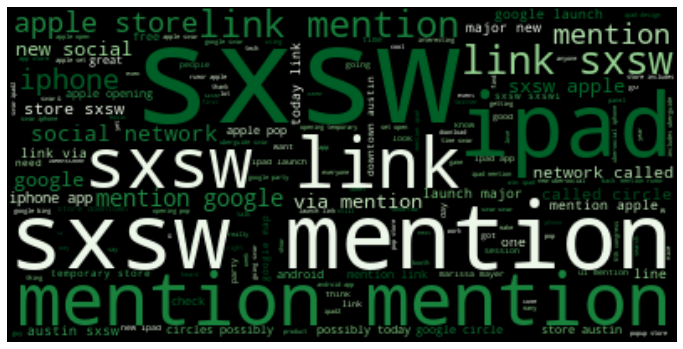

In [176]:
positive_cloud = generate_wordcloud(positive_tokens)

## Most Common Words Found in Negative Tweets


In [179]:
negative_corpus = negative_df['text'].to_list()
negative_corpus [:3]                            

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone']

In [180]:
#tokenize tweets
negative_tokens = tokenize_tweets(negative_corpus
#lemmatize tweets
neg_tokens_lemma = lemmatize_tokens(negative_tokens)
#remove stop words & punctuation using the same stop words list
negative_stop = remove_stop(neg_tokens_lemma, stop_list = stop_lst)

SyntaxError: invalid syntax (<ipython-input-180-fd979832d699>, line 4)

## Tweet Length

In [65]:
def count_words(doc):
    tokenizer_no_strip = TweetTokenizer(strip_handles=False)
    tokens = tokenizer_no_strip.tokenize(doc)
    return len(tokens)

df['token_count'] = df['text'].map(lambda x: count_words(x))
df.head()

,text,product,sentiment,raw_token_count,token_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,29,29
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,26,26
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,17,17
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,16,16
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,27,27


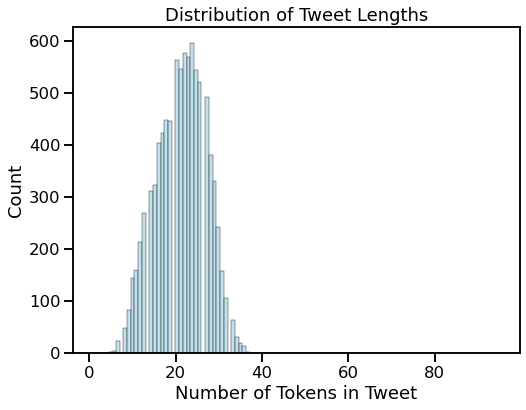

In [66]:
# visualize distribution of tweet lengths 
with sns.plotting_context(context='talk'):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(df['token_count'], color='lightblue', ax=ax)
    ax.set_title('Distribution of Tweet Lengths')
    ax.set_xlabel('Number of Tokens in Tweet');

### Bag of Words Stats

In [92]:
import nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [93]:
# Make a DataFrame from the Bigrams
pd.DataFrame(tweets_scored, columns=["Word","Freq"]).head(10)

,Word,Freq
0,"(#sxsw, @mention)",0.009790
1,"(ipad, 2)",0.009493
2,"(@mention, @mention)",0.008664
3,"(link, #sxsw)",0.007397
4,"(#sxsw, link)",0.006952
5,"(link, @mention)",0.006384
6,"(@mention, #sxsw)",0.004917
7,"(apple, store)",0.004734
8,"(@mention, google)",0.004079
9,"(social, network)",0.003948


In [94]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

tweet_pmi_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweet_pmi_finder.apply_freq_filter(3)

tweet_pmi_scored = tweet_pmi_finder.score_ngrams(bigram_measures.pmi)

In [96]:
# Make a DataFrame from the Bigrams with PMI
pd.DataFrame(tweet_pmi_scored,columns=['Words','PMI']).head(20)

,Words,PMI
0,"(#accordion, #toodamnlucky)",15.220051
1,"(#kawasaki, #thisisdare)",15.220051
2,"(#mwrc11, left-brain)",15.220051
3,"(#pubcamp, #kirkus)",15.220051
4,"(#sxswlatam, #latinasintech)",15.220051
5,"(#videogames, #tyson)",15.220051
6,"(barroom, brawls)",15.220051
7,"(boyfriend, aw)",15.220051
8,"(conceptual, graphing)",15.220051
9,"(deviantart, buys)",15.220051


### RegEx

In [98]:
## Select an example tweet
text =  corpus[9000]
text

'Dropped my MacBook pro as I was walking into #sxsw. iPad 2 sounding pretty appealing right now. Somehow I will adapt and overcome.'

In [99]:
## Select a second example tweet
text2=corpus[5]
text2

'@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd'

In [100]:
from nltk import regexp_tokenize
pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"
regexp_tokenize(text,pattern)

['Dropped',
 'my',
 'MacBook',
 'pro',
 'as',
 'I',
 'was',
 'walking',
 'into',
 'sxsw',
 'iPad',
 'sounding',
 'pretty',
 'appealing',
 'right',
 'now',
 'Somehow',
 'I',
 'will',
 'adapt',
 'and',
 'overcome']

In [102]:
import re
re.findall(r"(http://\w*\.\w*/+\w+)",text2)

['http://ht.ly/49n4M']

In [103]:
def clean_text(text,regex=True):
    from nltk.corpus import stopwords
    import string
    from nltk import word_tokenize,regexp_tokenize

    ## tokenize text
    if regex:
        pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"
        tokens= regexp_tokenize(text,pattern)
    else:
        tokens = word_tokenize(text)
        
    # Get all the stop words in the English language
    stopwords_list = stopwords.words('english')
    stopwords_list += string.punctuation
    
    stopped_tokens = [w.lower() for w in tokens if w not in stopwords_list]
    
    return stopped_tokens

In [104]:
## Other uses of RegEx for Tweet preprocessing
import re

def find_urls(string): 
    return re.findall(r"(http[s]?://\w*\.\w*/+\w+)",string)

def find_hashtags(string):
    return re.findall(r'\#\w*',string)

def find_retweets(string):
    return re.findall(r'RT [@]?\w*:',string)

def find_mentions(string):
    return re.findall(r'\@\w*',string)

## Stemming/Lemmatization

In [ ]:
def process_tweet(text,as_lemmas=False,as_tokens=True):
#     text=text.copy()
    for x in find_urls(text):
        text = text.replace(x,'')
        
    for x in find_retweets(text):
        text = text.replace(x,'')    
        
    for x in find_hashtags(text):
        text = text.replace(x,'')    

    if as_lemmas:
        from nltk.stem.wordnet import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        text = lemmatizer.lemmatize(text)
    
    if as_tokens:
        text = clean_text(text)
    
    if len(text)==0:
        text=''
            
    return text

In [ ]:
# @interact
def show_processed_text(i=(0,len(corpus)-1)):
    text_in = corpus[i]#.copy()
    print(text_in)
    text_out = process_tweet(text_in)
    print(text_out)
    text_out2 = process_tweet(text_in,as_lemmas=True)
    print(text_out2)

In [ ]:
corpus[:6]

## Text Vectorization

* Count vectorization
* Term Frequency-Inverse Document Frequency (TF-IDF)
* Word Embeddings (Deep NLP)

### Summary: Feature Engineering for Text Data

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

# Methods

## Text Preprocessing Approach

Describe and justify the process for preparing the data for analysis.

* Removed @mentions, links, non-ASCII characters, and words consisting of only numbers
* Generated several stopwords lists using NLTK's list as the baseline
* Evaluated several different methods for generating frequency in Documemt Term Matrix: binary, count, and count with Tf-Idf normalization
* Tried using uni-grams, uni-grams + bi-grams, and just bi-grams
* Tested with and without applying stemming and lemmatization using NLTK
* Testing using original data with imbalanced classes as well as randomly oversampled data



***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

# MODEL

## Text Classification - Sentiment Analysis

### Objective - Classifying Tweet Sentiments as Positive, Negative or Neither


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

Our modelling process was split in two: Binary Classification and Multiclass Classification. For each type of classification, data was prepared and a baseline dummy classifier model was trained to serve as a baseline. For comparison we trained/tested Random Forest models and Logistic Regression models for Multiclass Classification while adding on Multinomial Naive Bayes for the Binary Classification on top of these.

We evaluated each model and tuned hyperparameters with gridsearches that optimized for the recall macro scores since we wanted the models to correctly classify all classes. These steps were repeated after data was randomly oversampled.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

Tested Naive Bayes (Multinomial), Random Forest, and Logistic Regression classifiers
To determine optimal preprocessing steps, model type, and model hyperparameters, ran grid searches optimized for recall macro
Evaluated both binary (positive and negative) and multi-class (positive, negative, and no emotion) classification. Compared the all-in-one multi-class model to the performance if we used multi-class as the first pass, and the binary model as the second pass.

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [ ]:
df.head()

In [ ]:
## Check Value Counts for Product
df['emotion_in_tweet_is_directed_at'].value_counts()

In [ ]:
## Check Value Counts for Sentiment
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

## Preprocessing

In [ ]:
## Make X and y
y = df['is_there_an_emotion_directed_at_a_brand_or_product'].copy()
X = df['tweet_text'].copy()
X

### Train Test Split


In [ ]:
## Train Test Split (random state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                    random_state=42)
X_train

In [ ]:
## Check y_train value counts
y_train.value_counts(1)

### Tokenization & Vectorization

In [ ]:
## Make a TweekTokenizer from nltk.tokenize (preserve_case=False)
tokenizer = TweetTokenizer(preserve_case=False)

In [ ]:
## Make a TfIdf Vectorizer using tweet tokenizer's .tokenize method
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_list)

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

In [ ]:
## Compare the shape of X_train to X_train_tfidf

X_train.shape

In [ ]:
## Check the len of the vectorizer's vocabulary
len(vectorizer.vocabulary_)

## Baseline Model

In [ ]:
## Make and fit a random forest  (class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tfidf,y_train)


In [ ]:
def evaluate_classification(model, X_test_tf,y_test,cmap='Greens',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model (classifier): any sklearn classification model.
        X_test_tf (Frame or Array): X data
        y_test (Series or Array): y data
        cmap (str, optional): Colormap for confusion matrix. Defaults to 'Greens'.
        normalize (str, optional): normalize argument for plot_confusion_matrix. 
                                    Defaults to 'true'.
        classes (list, optional): List of class names for display. Defaults to None.
        figsize (tuple, optional): figure size Defaults to (8,4).
        
        X_train (Frame or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
        y_train (Series or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
    """
    
    ## Get Predictions and Classification Report
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    ## Plot Confusion Matrid and roc curve
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    ## if roc curve erorrs, delete second ax
    try:
        curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
    
def plot_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance

In [ ]:
## Evaluate Model using function
evaluate_classification(rf,X_test_tfidf,y_test,X_train=X_train_tfidf,y_train=y_train)

In [ ]:
pd.DataFrame(X_train_tfidf.todense(), columns=vectorizer.get_feature_names())

In [ ]:
# Plot the top 30 most important features
with plt.style.context('seaborn-talk'):

    ## Get Feature Importance
    importance = pd.Series(rf.feature_importances_,
                           index=vectorizer.get_feature_names())

    ## Take the .tail 30 and plot kind='barh'
    importance.sort_values().tail(30).plot(kind='barh')

## Pipelines and GridSearch for NLP

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn import set_config
set_config(display='diagram')

In [ ]:
text_pipe = Pipeline(steps=[
    ('count_vectorizer',CountVectorizer()),
    ('tf_transformer',TfidfTransformer(use_idf=True))
])
text_pipe

In [ ]:
## Test out the text pipeline on X_train
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

In [ ]:
## Make a full pipeline with the random forest model as the second step
full_pipe = Pipeline([('text_pipe',text_pipe),
                     ('clf',RandomForestClassifier(class_weight='balanced'))])
full_pipe

In [ ]:
# Modeling with full pipeline
full_pipe.fit(X_train,y_train)
evaluate_classification(full_pipe,X_test,y_test,X_train=X_train, y_train=y_train)

### GridSearching NLP Pipeline

In [ ]:
full_pipe.named_steps['text_pipe']

In [ ]:
## Make a tokenizer with TweetTokenizer

## Make params grid
## transformer params: use_idf/norm,smooth_idf
### tokenizers: try different TweetTokeinzier

## Vectorizer:stop_wqords/max_df/min_df,

## randomforest: criterin/max_depth
params = {'text_pipe__tf_transformer__use_idf':[True,False],
        'text_pipe__tf_transformer__norm':['l2','l1'],
         'text_pipe__tf_transformer__smooth_idf':[True,False],
          'text_pipe__count_vectorizer__stop_words':[stopwords_list,None],
#             'text_pipe__count_vectorizer__max_df':[1.0,0.95],
#           'text_pipe__count_vectorizer__min_df':[1,2,3],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 10, 30, 50]
         }

## Make and fit grid
grid = GridSearchCV(full_pipe,
                   params, cv=3, scoring='recall',n_jobs=-1,verbose=2)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_


In [ ]:
## Evluate the best_estimator
evaluate_classification(grid.best_estimator_, X_test,y_test, 
                        X_train=X_train, y_train=y_train)

### Get feature importances as text

### Gaussian Naive Bayes

In [ ]:

from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes.fit(X_tr,y_tr)
evaluate_classification(bayes,X_te,y_te,X_train=X_tr,y_train=y_tr)

In [ ]:
## Use text pipe to get X_train,X_test
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

In [ ]:
## Make a naive bayes classifier
nb_classifier = MultinomialNB()#alpha = 1.0e-08)
nb_classifier.fit(X_train_pipe,y_train)
evaluate_classification(nb_classifier,X_test_pipe,y_test, X_train=X_train_pipe,
                       y_train=y_train)

In [ ]:
# Make a new pipeline for bayes

nb_pipe = Pipeline(steps=[
    ('text_pipe',text_pipe),
    ('clf',MultinomialNB())
])


params = {'text_pipe__tf_transformer__use_idf':[True, False],
          'text_pipe__tf_transformer__norm':['l2','l1'],
          'text_pipe__tf_transformer__use_idf':[True,False],
          'text_pipe__tf_transformer__smooth_idf':[True,False],
#           'text_pipe__count_vectorizer__tokenizer':[ 
# #               None,                                       
#               TweetTokenizer(preserve_case=True).tokenize,
#               TweetTokenizer(preserve_case=False).tokenize],
          
          'text_pipe__count_vectorizer__stop_words':[None,stopwords_list],
#           'text_pipe__count_vectorizer__max_df':[1.0,0.95,0.9],
#           'text_pipe__count_vectorizer__min_df':[1,2,3],
          
         'clf__alpha':[0, 1],
         'clf__fit_prior':[True,False]}


## Make and fit grid
grid = GridSearchCV(nb_pipe,params,cv=3,scoring='recall_macro',
                   verbose=2, n_jobs=-1)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_


In [ ]:
## Evluate the best_estimator
best_pipe = grid.best_estimator_
evaluate_classification(best_pipe,X_test,y_test,X_train=X_train,y_train=y_train)

## Best Model

The best model for both binary and muli-class classification problems were both Logistic Regression. The models agreed on most preprocessing and model hyperparameters, but differed in a few ways:

### Multi-Class Model Results

Best model achieved ~60-65% balanced accuracy across all classes on unseen test data
~30% better than guessing randomly based on class distribution
Identified about the same percentage of True Positives for any class, although confused Positive and No Sentiment more often than either of these with Negative

### Binary Model Results

Best model achieved ~75% balanced accuracy across both classes on unseen test data
~25% better than guessing randomly based on class distribution
Better at predicting positive sentiment than negative: only ~10-15% of Positives misclassified as Negative, while ~30-40% of Negatives misclassified as Positive

# Results

Evaluate how well your work solves the stated business problem.

The winner of this task was the tuned oversampled logistic regression model with a recall macro score of 0.62. The tuned random oversampled logistic regression model also scored the same 0.62; however, since it got to the same score only after the random oversampling we are declaring the non-oversampled model as the winner.



***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Model Insights

The word clouds generated from top predictors of Positive and Negative sentiment seemed to capture the emotions fairly well. Ultimately, SMEs would need to weigh in on whether reviewing samples of tweets based on these predictors provided insights they didn't already have from other sources of customer sentiment.

Just from having read through some sample tweets during my EDA and preprocessing, I was able to glean some basic themes around what people were tweeting positively about and what they were tweeting negatively about.



For example, SXSW attendees sounded pretty positive about the new iPad 2, which was newly released at the time. Apple also had a pop-up store in downtown Austin that garnered a lot of chatter: some positive, but also some negative because people were annoyed at having to wait in long line to enter.

People expressed frustration about the battery life of their phones, as well as certain apps which had been designed to run on iOS or Android.

One of the biggest challenges would be determining a reasonable way to review the full text of tweets with certain themes to try to determine actionable insights. For example, I'm not surprised that words such as "cool" and "free" were top predictors of positive sentiment, but we would need to know exactly what people thought was "cool" and what "free" things they liked most.

SMEs, especially those who were familiar with what events were hosted and what merchandise was given away for free, would certainly need to interpret these further. Separating tweets into posisitve, negative, and neutral would only be the first step: reviewing the tweets themselves to determine themes in positive and negative sentiment would also be necessary.

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

***

As a proof-of-concept, I demonstrated that even simple models such as Logistic Regression can be trained on labeled data to predict sentiment more accurately than random guessing.

Since the Logistic Regression models are easy to interpret, I think they could provide useful insights for business stakeholders at a company looking to inform marketing and product strategies. My recommended approach would be to use the multi-class model to separate positive and negative tweets, and use the binary model as a second step to pull out the most important predictors of each sentiment.

Although these simple models only give us feature importances of n-grams, if we built a simple tool to search for each n-gram as a keyword in tweets, we could pull samples for subject matter experts to review and interpret before determining any next steps.



***


Today, it is more important than ever for businesses to be in tune with their customers. "Listening" to the public opinion on their products and services not only allows for them to maintain financial success, but also provides them with opportunities to stay competitive in the market. To sum up, our analysis showed the following:

1. How is Apple perceived as a company during the SXSW Conference, and how does this compare to Google as one of their main competitors?

During the SXSW Conference, 81.1% of all tweets related to Apple were positive compared to Google's 82%.
During the SXSW Conference, 16.1% of all tweets related to Apple were negative compared to Google's 14.9%
This suggests that both companies and their products and services are perceived mostly in a positive way.

2. How are Apple and Google's products and announcements perceived during the SXSW Conference? Are there specific pain points within the products that Apple should address?

Apple - Positives:

Tweets about Apple suggest that the temporary pop-up store announcement in downtown Austin has been received very well by Apple fans and generated a lot of excitement for the brand.
One of the most frequently talked about products was the iPad 2 which seems to have been launched during SXSW and sold in the Austin temporary pop-up store. Based on the tweets, Apple's launch of this product definitely generated a lot of buzz.
Samplers and free products/services were frequently mentioned as well.
Apple - Negatives:

The iPhone's battery is frequently discussed in negative tweets.
Design of the iPad was referred to as a "design headache."
There are several tweets mentioning Kara Swisher and references to Apple as a "fascist company."
Several apps are referred to as "battery killer" and the design of the News app seems to have not been received positively.
Google - Positives:

Google's party in Lustre Pearl generated a lot of buzz.
Marissa Mayer is mentioned extensively, so her talk was positively received.
Google's new social network project "Circle" seems to have caused a lot of excitement.
Microsoft's Bing search engine is mentioned in a negative way.
Google - Negatives:

Some users seem to be having issues with Android OS based on words such as "buggy", "replaced", and "painful."
Samsung is mentioned in tweets with relation to Android suggesting some users may prefer it to Google's products.
Users of Meetup are having problems with Android.

## Recommendations

In light of the insights we provided above, our recommendations for Apple are as follows:

Users are not happy with iPhone's battery performance and therefore more R&D in this area may be needed.
Some users also don't seem to like the iPad's design. It may be fruitful to look more into this issue and potentially conduct a survey with users to understand the downsides of the current design.
Users seem to be having several issues with Android apps. This may be a great opportunity for Apple to make sure these issues don't exist in iOS and market their products to these users.
The marketing strategy for the new pop-up store seems to have been successful. It can be employed in conjuction with other conferences or major events.
Based on the response to Google's party, it may be effective to throw a party during the next SXSW Conference to generate excitement.

## Limitations & Next Steps

The dataset we used was a crowdsourced dataset which brings about certain challenges, one of which is that labeling tweets as "Positive", "Negative" or "No emotion" can be a highly subjective exercise. What I may think is a positive tweet, someone else may interpret as negative. Additionally, the context of these tweets matter. Since we don't know the methodology of how the data was labeled, there could have been human error in labeling where a tweet that was intended to be sarcastic can be labeled incorrectly for example. This would negatively impact the quality of the data.

Furthermore, our dataset consisted of 9,092 tweets which is a fairly small number. After removing neutral tweets we were only left with around 3,000 tweets for the binary classification. So, the amount of data used was limited. Additionally, the class imbalance was pretty significant with approximately 61% of data being neutral, 33% being positive and 6% being negative. Arguably, the "Negative" class would be much more important than the "Neutral" class in trying to understand where the areas of improvement are for Apple in general.

As next steps, if Apple would like to generalize these models for different applications, we would definitely gather more data from Twitter and potentially other sources. Additionally, if the data had to be labeled by humans, we would set guidelines for what each class of tweet would consist of with examples to make sure that the labels didn't solely rely on emotions. Furthermore, taking the average of sentiment labels for each tweet would result in more accurate labels.

Lastly, the performance of the models could be greatly improved by rethinking this project with Neural Networks. In the future we would use Deep NLP to classify tweets.